In [1]:
from dataclasses import dataclass
from enum import Enum, auto
from typing import Self
from uuid import uuid4
from bamt.preprocessors import Preprocessor
import pandas as pd
from sklearn import preprocessing as pp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import re
from bamt.networks import HybridBN
import random
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler


YEAR = 2022

In [2]:
import geopy.distance

# coords_1 = (60.058750, 30.448056)
# coords_2 = (59.565278, 30.128056)
def get_distance(coords_1, coords_2):
    """lat, long"""
    return geopy.distance.geodesic(coords_1, coords_2).km

def to_8_chars_oktmo_unstrict(s):
    if len(s)==8:
        return s
    if len(s) ==11:
        return s[:8]
    raise ValueError(s)

def is_mun_district(oktmo):
    assert len(oktmo) == 8
    return oktmo[-3:] == "000"


def to_avg_on_person(df, features):
    res = df.copy()
    for f in features:
        res[f"{f}_avg_on_person"] = df[f]/df.popsize

    res = res.drop(features, axis=1)
    return  res

In [3]:
df = pd.read_csv(

    "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/mig whereabouts/inflow LO.csv")

Выделим ОКТМО из Ленобласти

In [4]:
oktmos = map(str,  df.oktmo.unique())

In [5]:
oktmos_lo = [x for x in oktmos if re.fullmatch(r"41\d+", x)]

In [6]:
del oktmos

In [7]:
len(oktmos_lo)

226

Определим численность населения. Проблема: удалось найти данные только за 2024 год

In [8]:
pop_size_df = pd.read_excel(

    "/Users/pishchulov/edu/matobes/НИР/outer_source/численность МО/Сhisl_MO_01-01-2024_only_LO.xlsx")

In [9]:
pop_size_df

,Коды территорий,Unnamed: 1,население,городское,сельское
0,4100000000,Ленинградская область,2035762,1373533,662229
1,41754000 0 0,Сосновоборский городской округ,63462,63462,0
2,41754000001 1 0 0 0,г Сосновый Бор,63462,63462,0
3,41603000 0 0,Бокситогорский муниципальный район,50855,39107,11748
4,41603101 0 0,Городское поселение Бокситогорское,15764,15480,284
...,...,...,...,...,...
271,41648418 0 0,Сельское поселение Нурминское,3338,0,3338
272,41648430 0 0,Сельское поселение Лисинское,1875,0,1875
273,41648443 0 0,Сельское поселение Тельмановское,26781,0,26781
274,41648444 0 0,Сельское поселение Трубникоборское,1599,0,1599


In [10]:
def discard_to_8_chars(s):
    if len(s) != 10:
        return s
    if s[-2:] == "00":
        return s[:-2]

In [11]:
pop_size_df["Коды территорий"] = pd.Series([discard_to_8_chars(x.replace(

    " ", "")) for x in map(str, pop_size_df["Коды территорий"])], dtype=str)

In [12]:
# pop_size_df_lo = pop_size_df[pop_size_df["Коды территорий"].isin(oktmos_lo)]

In [13]:
# set(oktmos_lo) - set(pop_size_df_lo["Коды территорий"])

Проблема: некоторые ОКТМО исчезли, потому что они эти населенные пункту переехали на новые коды. Проигнорируем.

In [14]:
del pop_size_df

In [15]:
# pop_size_df_lo=pop_size_df_lo.drop(["городское", "сельское"], axis = 1)
# pop_size_df_lo=pop_size_df_lo.set_axis(["oktmo", "name", "pop_size"], axis=1)
# pop_size_df_lo.sort_values("oktmo", inplace=True)
# pop_size_df_lo

Удалим муниципальные районы, потому что это агрегаты других МО

In [16]:
# pop_size_df_lo.pop_size.sum()

In [17]:
# mun_districts_lo = pop_size_df_lo[pop_size_df_lo.oktmo.apply(is_mun_district)]
# mun_districts_lo

In [18]:
# pop_size_df_lo=pop_size_df_lo[~pop_size_df_lo.oktmo.apply(is_mun_district)]
# pop_size_df_lo.pop_size.sum()

### Подготовим данные о среде. 

In [19]:
allmun = pd.read_csv(

    "/Users/pishchulov/edu/matobes/НИР/outer_source/rosstat_allmun/allmuns/popsize (allmun).csv")
allmun[["oktmo"]] = allmun[["oktmo"]].astype(str)
allmun["from_lo"] = [bool(re.fullmatch(r"41\d+", x)) for x in allmun.oktmo]
allmun = allmun[(allmun.from_lo) & (allmun.year == YEAR)]
allmun = allmun[["oktmo", "name", "year", "popsize"]].set_index("oktmo")
allmun["popsize"] = allmun["popsize"].astype(int)

In [20]:
allmun

,name,year,popsize
oktmo,,,
41603000,Бокситогорский муниципальный район,2022,47236
41603101,Бокситогорское,2022,14606
41603102,Пикалёвское,2022,19250
41603155,Ефимовское,2022,4389
41603412,Большедворское,2022,1486
...,...,...,...
41648430,Лисинское,2022,1703
41648443,Тельмановское,2022,13191
41648444,Трубникоборское,2022,1479


## Данные о среде

Нет ITMO2 данных за 2023 год, поэтому используем 2022.

In [21]:

mo_features = allmun
# files = [
#     "shoparea",
#     "foodseats",
#     "agrprod",
#     "beforeschool",
#     "schoolnum",  # тут нет требуемых районов
#     "museums",
#     "theatres",
#     "musartschool",
#     "hospitalcap",
#     "pollutionvol",
#     "popsize",
#     "retailturnover",
#     "livarea",

# ]
files = """parks
schoolnum
cliniccap
sportsvenue
consnewareas
popsize
livestock
saldo internat
consnewapt
budincome
musartschool
foodservturnover
goodcompanies
invest
factoriescap
shoparea
museums
agrprod
roadslen
hospitals
outflow
foodseats
servicesnum
avgsalary
harvest
funds
library
cultureorg
saldo interreg
avgemployers
naturesecure
goodcompincome
visiblecompanies
retailturnover
beforeschool
theatres
saldo reg
docsnum
livarea
badcompanies""".split('\n')

files_about_mo = ["sportsvenue", "invest",

                   "shoparea", "roadslen", "hospitals"]

data_point_count = []
allmun_by_feat = {}
for f in files_about_mo:
    d = pd.read_csv(
        f"/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/superdataset/features separately/{f} (allmun).csv")
    d[["oktmo"]] = d[["oktmo"]].astype(str)
    d["from_lo"] = [bool(re.fullmatch(r"41\d+", x)) for x in d.oktmo]
    allmun_by_feat[f] = d[(d.from_lo)]
    d_lo = d[(d.from_lo) 
             & (d.year == 2022)
             ]
    if len(d_lo):
        data_point_count.append((f, len(d_lo)))
        # print(f" f== {f} {len(d_lo)}")
    d = d[(d.oktmo.isin(mo_features.index)) & (
        d.year == 2022)].drop(["from_lo"], axis=1)
    if len(d) == 0:
        print(f"error in {f}")
    else:
        mo_features = mo_features.join(d.set_index("oktmo").iloc[:, -1:], )
    
# pd.DataFrame(data_point_count, columns=["feat", "num"]).sort_values("num", ascending=False)
mo_features["oktmo"] = mo_features.index
mun_districts = mo_features[pd.Series(
    mo_features.index, index=mo_features.index).apply(is_mun_district)]["name"]
mo_features = mo_features[~mo_features.oktmo.apply(is_mun_district)]
cols_with_nan = list(mo_features.columns[mo_features.isna().sum(axis=0)>=1])
for c in cols_with_nan:
    mo_features[c] = mo_features[c].fillna(mo_features[c].median())
mo_features_abs = mo_features.copy()
mo_features = to_avg_on_person(mo_features, features=files_about_mo)
AVG_FEATURE_NAMES = [f"{f}_avg_on_person" for f in files_about_mo] 

scaler = MinMaxScaler()
 
df_scaled = scaler.fit_transform(mo_features[AVG_FEATURE_NAMES].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=AVG_FEATURE_NAMES, index= mo_features.index)
mo_features[AVG_FEATURE_NAMES] = df_scaled


# mo_features
mo_features

,name,year,popsize,oktmo,sportsvenue_avg_on_person,invest_avg_on_person,shoparea_avg_on_person,roadslen_avg_on_person,hospitals_avg_on_person
oktmo,,,,,,,,,
41603101,Бокситогорское,2022,14606,41603101,0.209362,0.002344,0.297731,0.042840,0.012232
41603102,Пикалёвское,2022,19250,41603102,0.209585,0.002442,0.238284,0.025938,0.007362
41603155,Ефимовское,2022,4389,41603155,0.294187,0.000601,0.124689,0.373534,0.193568
41603412,Большедворское,2022,1486,41603412,0.374693,0.000136,0.059730,0.226653,0.190449
41603416,Борское,2022,3272,41603416,0.313680,0.000375,0.051948,0.086449,0.172258
...,...,...,...,...,...,...,...,...,...
41648418,Нурминское,2022,2977,41648418,0.194500,0.002299,0.157915,0.052161,0.091081
41648430,Лисинское,2022,1703,41648430,0.187845,0.000282,0.038781,0.289960,0.338290
41648443,Тельмановское,2022,13191,41648443,0.015796,0.002013,0.267001,0.003847,0.036748


Проверим, что нет NAN

In [22]:
mo_features[mo_features.isna().sum(axis=1)>=1]

,name,year,popsize,oktmo,sportsvenue_avg_on_person,invest_avg_on_person,shoparea_avg_on_person,roadslen_avg_on_person,hospitals_avg_on_person
oktmo,,,,,,,,,


In [23]:

# mun_districts

#### Список муниципальных образований без муниципальных округов

In [24]:
mun_units = mo_features[~pd.Series(
    mo_features.index, index=mo_features.index).apply(is_mun_district)][["name", "popsize"]+AVG_FEATURE_NAMES]

In [25]:
len(mo_features), len(mun_units)

(187, 187)

In [26]:
geo = pd.read_csv(
    "/Users/pishchulov/edu/matobes/НИР/outer_source/settlements_12032021/data.csv")
geo = geo[~geo.oktmo.isnull()]
geo.oktmo = geo.oktmo.apply(round).apply(int).apply(str)
geo[["latitude_dd", "longitude_dd"]] = geo[[
    "latitude_dd", "longitude_dd"]].astype(float)
# geo.oktmo = pd.Series([str(int(float(x))) for x in geo.oktmo], index = geo.index)
geo["from_lo"] = [bool(re.fullmatch(r"41\d+", str(x))) for x in geo.oktmo]
geo = geo[geo.from_lo]
geo["oktmo"] = geo.oktmo.apply(to_8_chars_oktmo_unstrict)

longitude = pd.Series(geo.groupby("oktmo")["longitude_dd"].mean(), name = "longitude_dd")
latitude = pd.Series(geo.groupby("oktmo")["latitude_dd"].mean(), name="latitude_dd")
mun_units= mun_units.join(latitude).join(longitude)

# Генерация популяции

Распределения по полу и возрасту есть только для муниципальных районов.
migration/ITMO-2/popsize/data0.xlsx

In [27]:
@dataclass
class AgeGroup:
    lo: int
    hi: int

    def __str__(self):
        return f"{self.lo}-{self.hi}"

    @staticmethod
    def from_str(s):
        lo, hi = list(map(int, s.split('-')))
        return AgeGroup(lo=lo, hi=hi)

    def get_random_age(self):
        return random.choice(list(range(self.lo, self.hi+1)))


age_groups = [
    AgeGroup(0, 0),
    AgeGroup(1, 4),
    AgeGroup(5, 9),
    AgeGroup(10, 14),
    AgeGroup(15, 19),
    AgeGroup(20, 24),
    AgeGroup(25, 29),
    AgeGroup(30, 34),
    AgeGroup(35, 39),
    AgeGroup(40, 44),
    AgeGroup(45, 49),
    AgeGroup(50, 54),
    AgeGroup(55, 59),
    AgeGroup(60, 64),
    AgeGroup(65, 69),
    AgeGroup(70, 74),
    AgeGroup(75, 79),
    AgeGroup(80, 84),
    AgeGroup(85, 89),
    AgeGroup(90, 94),
    AgeGroup(95, 99),
    AgeGroup(100, 100),
]
gender_age_dist_by_district_oktmo = {}
for mun_district_oktmo, mun_district_name_series in pd.DataFrame(mun_districts).iterrows():
    mun_district_name = mun_district_name_series.iloc[0]
    mun_district_first_name = mun_district_name.split()[0]
    try:
        df = pd.read_excel(

            "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/popsize/data0.xlsx", sheet_name=mun_district_first_name)
    except ValueError:
        df = pd.read_excel(

            "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/popsize/data0.xlsx", sheet_name=mun_district_first_name+" ")

    col_num = list(df.iloc[0, :]).index(YEAR)
    year_data = df.iloc[:, col_num]
    males = []
    females = []
    for i, ag in enumerate(age_groups):
        female = year_data.iloc[6+i*4]
        male = year_data.iloc[7+i*4]
        males.append(male)
        females.append(female)

    gender_age_dist = pd.DataFrame(
        {"male": males, "female": females}, index=list(map(str, age_groups)))
    gender_age_dist = gender_age_dist.fillna(gender_age_dist.mean())
    gender_age_dist_by_district_oktmo[mun_district_oktmo] = gender_age_dist

In [28]:
gender_age_dist_by_district_oktmo

{'41603000':             male  female
 0-0       162.00   142.0
 1-4       949.00   867.0
 5-9      1328.00  1280.0
 10-14    1388.00  1344.0
 15-19    1279.00  1219.0
 20-24    1046.00   966.0
 25-29    1130.00  1032.0
 30-34    1906.00  1731.0
 35-39    2339.00  2143.0
 40-44    2112.00  2040.0
 45-49    1936.00  2002.0
 50-54    1591.00  1616.0
 55-59    1554.00  1834.0
 60-64    1866.00  2557.0
 65-69    1498.00  2329.0
 70-74    1137.35  1263.4
 75-79    1137.35  1263.4
 80-84     446.00  1232.0
 85-89     160.00   630.0
 90-94      49.00   269.0
 95-99       7.00    33.0
 100-100     1.00     2.0,
 '41606000':            male  female
 0-0       175.0   147.0
 1-4      1089.0  1001.0
 5-9      1443.0  1383.0
 10-14    1407.0  1332.0
 15-19    1285.0  1278.0
 20-24    1283.0  1120.0
 25-29    1357.0  1187.0
 30-34    2083.0  1834.0
 35-39    2373.0  2165.0
 40-44    2137.0  2054.0
 45-49    1932.0  1860.0
 50-54    1609.0  1569.0
 55-59    1570.0  1913.0
 60-64    1705.0  2189.0
 6

##### Построим набор данных, следующих имеющемуся распредление пола и возраста

In [29]:
def gender_age_dist_to_population(gender_age_dist_by_district_oktmo):
    """Принимает распределение по полу и возрасту для каждого мун. района.
    Генереириует популяцию.
    Разворачивает статистики в выборку, 
    предполагая, что в каждой возрастной группе возраст распредлен равномерно"""
    age_sex_population = []
    for district_oktmo, age_sed_distribution_df in gender_age_dist_by_district_oktmo.items():
        for age_group_str, row in age_sed_distribution_df.iterrows():
            age_group = AgeGroup.from_str(age_group_str)
            males_cnt = int(row["male"])
            females_cnt = int(row["female"])
            for _ in range(males_cnt):
                age_sex_population.append(
                    (age_group.get_random_age(), 1, district_oktmo))
            for _ in range(females_cnt):
                age_sex_population.append(
                    (age_group.get_random_age(), 0, district_oktmo))
    population = pd.DataFrame(age_sex_population, columns=[
        "age", "male", "district_oktmo"]).sample(frac=1).reset_index(drop=True)
    return population

Популяция по мун. районам

In [30]:
population = gender_age_dist_to_population(gender_age_dist_by_district_oktmo)
mun_district_population = population
population

,age,male,district_oktmo
0,31,0,41618000
1,53,1,41612000
2,26,1,41612000
3,37,1,41612000
4,40,1,41639000
...,...,...,...
2074072,22,0,41636000
2074073,22,1,41642000
2074074,76,0,41624000
2074075,11,0,41609000


### Определим образование. Построим условное распределение образования от пола и возраста.

In [31]:
rlms = pd.read_excel("/Users/pishchulov/edu/matobes/НИР/Data_RLMS.xlsx")
data = rlms[["age", "male", "educ", "lnwage", "children"]]

#### Обучим классифкатор для предсказания уровня образования на данных RLMS

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    
    data[["age", "male"]], data['educ'], test_size=.2)
educ_clsf = XGBClassifier()
educ_clsf.fit(X_train, y_train) 
preds = educ_clsf.predict(X_test)  # TODO predict proba
# accuracy == 40% - на первый взгляд довольно плохой результат,
# но все равно гораздо лучше, чем назначать уровень образования исходя из общих рассуждений и здравого смысла
accuracy_score(y_test, preds)

0.41161290322580646

#### Применим классификатор, чтобы назначить уровень образования для агентов из популяции

In [33]:
population[["age", "male"]]

,age,male
0,31,0
1,53,1
2,26,1
3,37,1
4,40,1
...,...,...
2074072,22,0
2074073,22,1
2074074,76,0
2074075,11,0


In [34]:
population["educ"] =educ_clsf.predict(population[["age", "male"]])

In [35]:
population

,age,male,district_oktmo,educ
0,31,0,41618000,3
1,53,1,41612000,1
2,26,1,41612000,3
3,37,1,41612000,3
4,40,1,41639000,1
...,...,...,...,...
2074072,22,0,41636000,3
2074073,22,1,41642000,2
2074074,76,0,41624000,1
2074075,11,0,41609000,1


### Определим зарплату. Построим зависимость от пола, возраста и образования

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    
    data[["age", "male", "educ"]], data['lnwage'], test_size=.2)
wage_regressor = XGBRegressor()
wage_regressor.fit(X_train, y_train)
preds = wage_regressor.predict(X_test)
mape(y_test, preds)  # mape == 0.05 - отличный результат.

0.04981506201323845

In [37]:
population["lnwage"] = wage_regressor.predict(
    
    population[["age", "male", "educ"]])

### Определим количество детей

In [38]:
X_train, X_test, y_train, y_test = train_test_split(data[["age", "male", "educ", "lnwage"]], data["children"],
                                                    test_size=.2)
children_regressor = XGBRegressor()
children_regressor.fit(X_train, y_train)
preds = children_regressor.predict(X_test).round()
mae(y_test, preds)

0.7058064516129032

In [39]:
population["children"] = children_regressor.predict(
    
    population[["age", "male", "educ", "lnwage"]]).round().astype(int)

In [40]:

data["male"] = rlms.male.astype(str)
data["educ"] = rlms.educ.astype(str)

# set encoder and discretizer
encoder = pp.LabelEncoder()
discretizer = pp.KBinsDiscretizer(
    
    n_bins=5, encode="ordinal", strategy="uniform")

# create preprocessor object with encoder and discretizer
p = Preprocessor([("encoder", encoder), ("discretizer", discretizer)])

# discretize data for structure learning
discretized_data, est = p.apply(data)

# get information about data
info = p.info

# initialize network object
bn = HybridBN(use_mixture=True, has_logit=True)

# add nodes to network
bn.add_nodes(info)

# using mutual information as scoring function for structure learning
bn.add_edges(
    discretized_data,
    #  scoring_function=('MI',)
)

# or use evolutionary algorithm to learn structure

bn.add_edges(discretized_data)

bn.fit_parameters(data)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [41]:
# bn.save("pop.json")
bn.plot('mixture.html')
bn.validate(info)

True

In [42]:
sampled_data = bn.sample(10_000, progress_bar=False)
# sampled_data.children = sampled_data.children.astype(int)
sampled_data.male = sampled_data.male.astype(int)
sampled_data.age = sampled_data.age.astype(int)

In [43]:
sampled_data

,lnwage,children,male,educ,age
0,9.605369,2,1,3,35
1,10.369692,2,1,2,42
2,10.799414,1,1,1,44
3,9.468506,1,0,1,53
4,9.997203,2,1,1,48
...,...,...,...,...,...
9995,9.565414,4,1,3,41
9996,10.053319,2,0,2,58
9997,10.356624,0,0,3,26
9998,9.271893,0,1,2,21


# Сгенерирруем популяцию для каждого МО из Ленобласти

In [44]:
def to_district_oktmo(oktmo):
    assert len(oktmo) == 8
    return oktmo[:5]+"000"

In [45]:
from functools import cache



def get_mun_unit_population(mun_units, mun_district_population):
    mun_unit_population = pd.DataFrame(columns=["age", "male", "oktmo"])
    for mun_unit in tqdm(list(mun_units.reset_index().itertuples(index=False))):
        district_oktmo = to_district_oktmo(mun_unit.oktmo)
        pop    = (mun_district_population[mun_district_population.district_oktmo == district_oktmo]
               .sample(mun_unit.popsize)[["age", "male"]])
        pop["oktmo"] = mun_unit.oktmo
        pop = pd.DataFrame(pop, columns=["age", "male", "oktmo"])
        mun_unit_population = pd.concat([mun_unit_population, pop])
    mun_unit_population["age"] = mun_unit_population["age"].astype(int)
    mun_unit_population["male"] = mun_unit_population["male"].astype(int)
    mun_unit_population["oktmo"] = mun_unit_population["oktmo"].astype(str)
    return mun_unit_population


    

mun_unit_population = get_mun_unit_population(
    mun_units, mun_district_population)

100%|██████████| 187/187 [00:18<00:00,  9.93it/s]


In [46]:
mun_unit_population

,age,male,oktmo
350763,56,1,41603101
2016734,46,1,41603101
181352,69,0,41603101
538846,33,1,41603101
247260,48,1,41603101
...,...,...,...
878376,16,0,41648464
308756,49,1,41648464
1523322,35,0,41648464
1874884,22,1,41648464


### Определим образование, зарплату, количество детей для популяции

In [47]:
mun_unit_population["educ"] = educ_clsf.predict(
    
    mun_unit_population[["age", "male"]])
    
mun_unit_population["lnwage"] = wage_regressor.predict(
        mun_unit_population[["age", "male", "educ"]])
mun_unit_population["children"] = children_regressor.predict(
    mun_unit_population[["age", "male", "educ", "lnwage"]]).round().astype(int)

In [48]:
mun_unit_population # TODO указать конкретные возраста детей. если до 6 лет, то вероятность миграци поменяется

,age,male,oktmo,educ,lnwage,children
350763,56,1,41603101,1,9.751864,2
2016734,46,1,41603101,1,9.859557,2
181352,69,0,41603101,1,8.963122,2
538846,33,1,41603101,3,10.134507,1
247260,48,1,41603101,1,9.760914,1
...,...,...,...,...,...,...
878376,16,0,41648464,1,9.301373,0
308756,49,1,41648464,1,9.379914,1
1523322,35,0,41648464,3,9.983811,1
1874884,22,1,41648464,2,9.794912,0


In [49]:
mun_units

,name,popsize,sportsvenue_avg_on_person,invest_avg_on_person,shoparea_avg_on_person,roadslen_avg_on_person,hospitals_avg_on_person,latitude_dd,longitude_dd
oktmo,,,,,,,,,
41603101,Бокситогорское,14606,0.209362,0.002344,0.297731,0.042840,0.012232,59.476894,33.979697
41603102,Пикалёвское,19250,0.209585,0.002442,0.238284,0.025938,0.007362,59.513056,34.177222
41603155,Ефимовское,4389,0.294187,0.000601,0.124689,0.373534,0.193568,59.499905,34.649925
41603412,Большедворское,1486,0.374693,0.000136,0.059730,0.226653,0.190449,59.632269,34.005313
41603416,Борское,3272,0.313680,0.000375,0.051948,0.086449,0.172258,59.385208,33.860675
...,...,...,...,...,...,...,...,...,...
41648418,Нурминское,2977,0.194500,0.002299,0.157915,0.052161,0.091081,59.567315,31.018889
41648430,Лисинское,1703,0.187845,0.000282,0.038781,0.289960,0.338290,59.329228,30.744259
41648443,Тельмановское,13191,0.015796,0.002013,0.267001,0.003847,0.036748,59.701944,30.573056


In [50]:
inflow = pd.read_csv(
    "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/superdataset/mig data/total/inflow/inflow 2022 (allmun).csv")
outflow = pd.read_csv(
    "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/superdataset/mig data/total/outflow/outflow 2022 (allmun).csv")
inflow['oktmo'] = inflow['oktmo'].astype(str)
outflow['oktmo'] = outflow['oktmo'].astype(str)
inflow = inflow[inflow.oktmo.isin(mun_units.index)]
inflow = inflow.set_index("oktmo")[["inflow"]].astype(int)
outflow = outflow[outflow.oktmo.isin(mun_units.index)]
outflow = outflow.set_index("oktmo")[["outflow"]].astype(int)

mun_units = mun_units.join(inflow).join(outflow)
mun_units["saldo"] = mun_units.inflow - mun_units.outflow

In [51]:
# mun_units.sort_values("saldo").tail(50)

## Степенное распределение числа жителей в МО

In [52]:
import numpy as np
from scipy.stats import powerlaw
from scipy.optimize import minimize
import matplotlib.pyplot as plt

a = 0.8
loc = 3
scale = 10
bins = 100

In [53]:
# def example_fit():
#     fig, ax = plt.subplots(1, 1)
#     np.linspace(powerlaw.ppf(0.01, a, loc=loc, scale=scale),
#                     powerlaw.ppf(0.999, a, loc=loc, scale=scale), 1000)
#     ax.plot(x, powerlaw.pdf(x, a),
#             'r-', lw=5, alpha=0.6, label='powerlaw pdf')
#         powerlaw(a, loc=loc, scale=scale)
#     ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
#         powerlaw.rvs(a, loc =loc, scale=scale, size=1000)
#         ist(r, density=True, bins=bins, histtype='stepfilled', alpha=0.2)
#     ax.set_xlim([x[0], x[-1]])
#     ax.legend(loc='best', frameon=False)
#     params = powerlaw.fit(r, method="MLE",)
#     t, loc_fit, scale_fit = params
#     t = powerlaw(a_fit, loc_fit, scale_fit).pdf(x)
#     ax.plot(x, y_fit,
#         'r-', lw=5, alpha=0.6, label='powerlaw pdf', color="green")
#     plt.show()




# example_fit()

In [54]:
ps = mun_units.popsize.sort_values()

(0.2995730938561535, 438.99999999999994, 90132.00000000001)


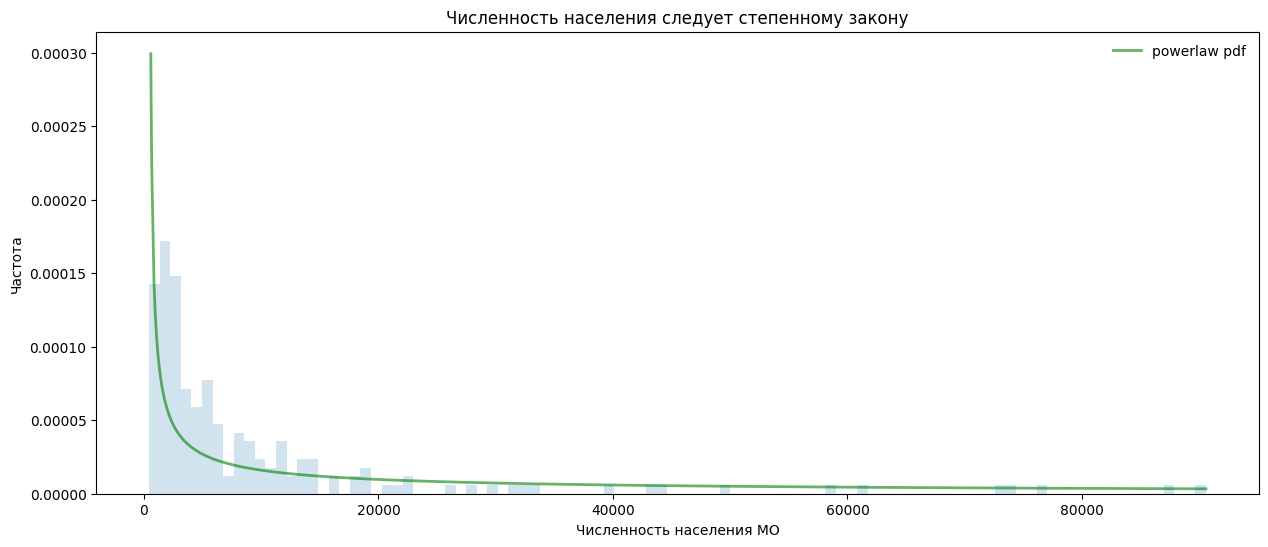

In [55]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(15)
params = powerlaw.fit(ps, method="MLE",)
a_fit, loc_fit, scale_fit = params
print(params)
y_fit = powerlaw(a_fit, loc_fit, scale_fit).pdf(ps)
ax.hist(ps, density=True, bins=bins, histtype='stepfilled', alpha=0.2, 
        label = "")
ax.plot(ps[2:], y_fit[2:],
        'r-', lw=2, alpha=0.6, label='powerlaw pdf', color="green")

ax.legend(loc='best', frameon=False)
plt.xlabel('Численность населения МО')
plt.ylabel('Частота')
plt.title("Численность населения следует степенному закону")
plt.show()

In [56]:
sd = pd.read_csv(
    
    "/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/superdataset/superdataset (full data).csv")
sd["oktmo"] = sd["oktmo"].astype(str)
sd["year"] = sd["year"].astype(str)
sd = sd[sd.oktmo.isin(mun_units.index)]

In [57]:
# mun_units.sort_values("popsize", ascending=False).head(50)

#### Гипотеза: в больших городах доля приезжающих (уезжающих) больше

In [58]:
mun_units["saldo_rel"] = mun_units.saldo  / mun_units.popsize
mun_units["in_and_out_flow"] = mun_units.inflow + mun_units.outflow


In [59]:
df = mun_units.sort_values("popsize", ascending=False)
# df["inflow_rel"] = df.inflow/df.popsize
# df["outflow_rel"] = df.outflow/df.popsize
# df = df.drop(["inflow", "outflow"], axis=1)
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df.popsize,
        y=df.saldo,
    )
)

<Axes: >

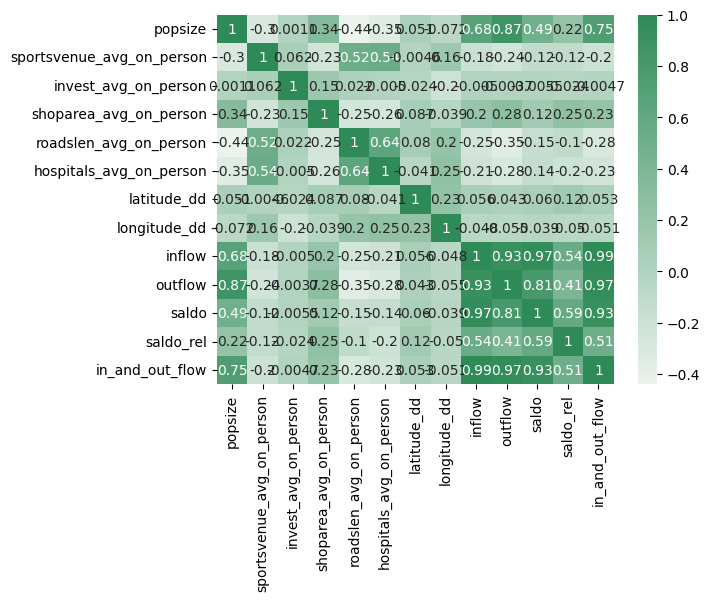

In [60]:
corr = df.drop("name", axis=1).corr()
sns.heatmap(corr,  annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap=sns.light_palette("seagreen", as_cmap=True))

In [61]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df.popsize,
        y=df.inflow,
    )
)

Число миграционных взаимодействий in_and_out_flow коррелирует с численностью населения.

Можно построить граф, в котором узел - город, ребро - переезд между городами.

Следует ли in_and_out_flow степенному закону?

(0.2100683069241509, 32.99999999999999, 27332.000000000004)


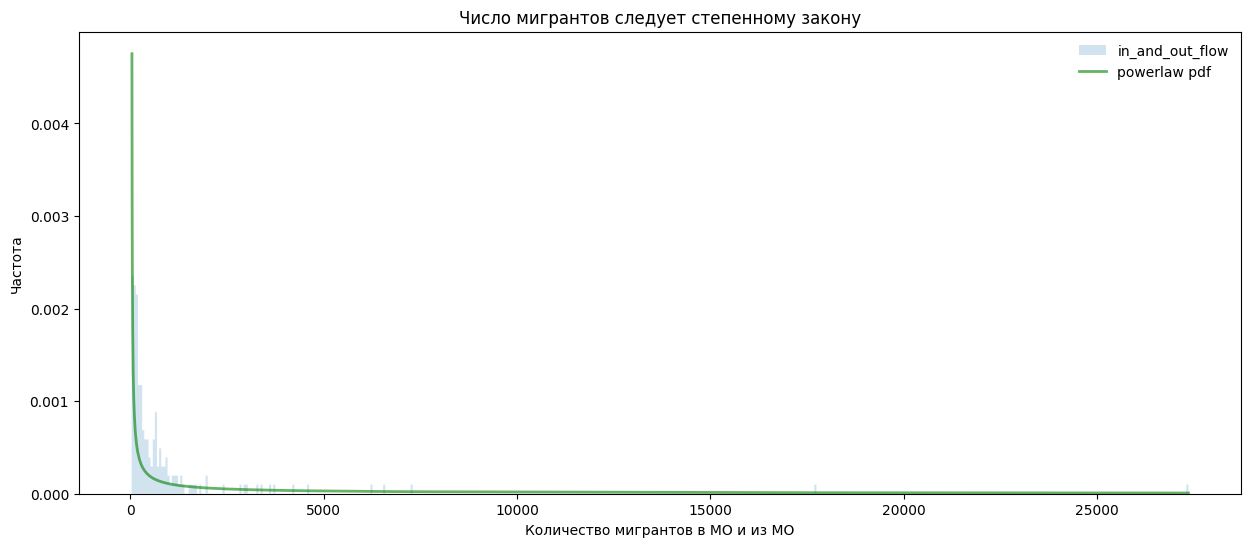

In [62]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(15)
mun_units = mun_units.sort_values("in_and_out_flow")
in_and_out_flow = mun_units.in_and_out_flow
params = powerlaw.fit(in_and_out_flow, method="MLE",)
a_fit, loc_fit, scale_fit = params
print(params)
y_fit = powerlaw(a_fit, loc_fit, scale_fit).pdf(in_and_out_flow)
y_hist, x, _ =ax.hist(in_and_out_flow, density=True, bins=500, histtype='stepfilled', alpha=0.2,
                      label = "in_and_out_flow")
ax.plot(in_and_out_flow[1:], y_fit[1:],
        'r-', lw=2, alpha=0.6, label='powerlaw pdf', color="green")
ax.legend(loc='best', frameon=False)
plt.xlabel('Количество мигрантов в МО и из МО')
plt.ylabel('Частота')
plt.title("Число мигрантов следует степенному закону")
plt.show()

#### Характеристики муниципальных районов (9 шт.)

In [63]:
df = pd.read_csv("/Users/pishchulov/edu/matobes/НИР/outer_source/migration/ITMO-2/migforecasting/clustering/datasets/superdataset-24 alltime-clust (oktmo).csv")
df["oktmo"] = df.oktmo.astype(str)

In [64]:
mun_distrcits_lo = [x for x in df.oktmo if re.fullmatch(r"41\d+", x)]
# df[df.oktmo.isin(mun_distrcits_lo)]

# Модель

In [65]:
mun_unit_population

,age,male,oktmo,educ,lnwage,children
350763,56,1,41603101,1,9.751864,2
2016734,46,1,41603101,1,9.859557,2
181352,69,0,41603101,1,8.963122,2
538846,33,1,41603101,3,10.134507,1
247260,48,1,41603101,1,9.760914,1
...,...,...,...,...,...,...
878376,16,0,41648464,1,9.301373,0
308756,49,1,41648464,1,9.379914,1
1523322,35,0,41648464,3,9.983811,1
1874884,22,1,41648464,2,9.794912,0


### pull-факторы

In [66]:
age_distance_conditional_distribution = pd.DataFrame({
    "0-14": [9.9, 29.8, 12.3, 12.0, 11.5, 8.2, 14.5, 1.8],
    "16-16": [3.7, 28, 22.2, 17.9, 12.2,  5.7, 9.2, 1.1],
    "18-18": [2.2, 13.2, 16, 20.7, 19.7, 10.9, 15.9, 1.4],
    "15-19": [3.4, 19.0, 17.7, 19.0, 16.5, 9, 14, 1.4],
    "20-24": [5.0, 17.5, 12.7, 15.1, 16.1, 11.1, 20.3, 2.2],
    "25-49": [8, 23.2, 11.3, 12.3, 13.4, 10.5, 19, 2.3],
    "50-64": [9.2, 24.7, 10.3, 10.3, 11.4, 9.3, 21.6, 3.2],
    "65-100": [8.3, 25.4, 12.5, 12.4, 12.8, 9.1, 17, 2.5]
}, index = ["1-10", "10-50","50-100", "100-200", "200-500", "500-1000", "1000-5000", "5000-10000"])
# источник - https://journals.kantiana.ru/upload/iblock/a91/1_4-22.pdf    doi: 10.5922/2079-8555-2023-2-1
age_distance_conditional_distribution

,0-14,16-16,18-18,15-19,20-24,25-49,50-64,65-100
1-10,9.9,3.7,2.2,3.4,5.0,8.0,9.2,8.3
10-50,29.8,28.0,13.2,19.0,17.5,23.2,24.7,25.4
50-100,12.3,22.2,16.0,17.7,12.7,11.3,10.3,12.5
100-200,12.0,17.9,20.7,19.0,15.1,12.3,10.3,12.4
200-500,11.5,12.2,19.7,16.5,16.1,13.4,11.4,12.8
500-1000,8.2,5.7,10.9,9.0,11.1,10.5,9.3,9.1
1000-5000,14.5,9.2,15.9,14.0,20.3,19.0,21.6,17.0
5000-10000,1.8,1.1,1.4,1.4,2.2,2.3,3.2,2.5


In [82]:
# Признаки: age	 male	oktmo	educ	lnwage	children
def p1_mo_size(agent, target_mo_pop_size):
    """ ( p1 ) 
    Реализует правило 'В большом городе ожидаем большой приток населения' 
    target_mo_pop_size - численность населения города, в который рассматривается переезд
    """

    return target_mo_pop_size


def p2_conditional_distribution_age_and_distance(agent, distance):
    """ ( p2 )"""
    distrib = None
    for age_group_str in age_distance_conditional_distribution.columns:
        lo, hi = list(map(int, age_group_str.split('-')))

        if lo <= agent.age <= hi:
            distrib = age_distance_conditional_distribution[age_group_str]
            break
    for dist_option in distrib.index:
        lo, hi = list(map(int, dist_option.split('-')))
        if lo <= distance <= hi:
            return distrib[dist_option]
    raise ValueError(f"Can not find distance option. Agent: {agent}")


distance_distribution = pd.Series([37.8, 12.3, 12.4, 11.8, 8.3, 125.3, 2.1],
                                  index=["1-50", "50-100", "100-200", "200-500", "500-1000", "1000-5000", "5000-10000"])


def p3_distance_distribution(agent, distance):
    """ ( p3 )"""
    # источник - https://journals.kantiana.ru/upload/iblock/a91/1_4-22.pdf    doi: 10.5922/2079-8555-2023-2-1
    # страница 7
    for dist_option in distance_distribution.index:
        lo, hi = list(map(int, dist_option.split('-')))
        if lo <= distance <= hi:
            return distance_distribution[dist_option]



educ_lavel_gender_dist = pd.DataFrame(
    {"1": [1, 1.531, 2.511, 3.021], "0": [1, 1.669, 4.116, 6.290]})
# 1 - male, 0, female


def p4_education_non_student(agent):
    """  ( p4 )
    Реализует зависимсость между образованием и дальностью поездки
    Источник - Spatial Flexibility in Job Mobility: Macrolevel Opportunities and Microlevel Restrictions"""
    return educ_lavel_gender_dist.loc[int(agent.educ), str(agent.male)]


migration_intensity_by_age = pd.Series([12, 8, 7, 10, 25, 40, 25, 22.5, 17, 12, 10, 8, 7, 6, 5],
                                       index=["0-5", "5-10", "10-15", "16-16", "17-17", "18-18", "19-25",
                                              "25-30", "30-35", "35-40", "40-45", "45-50", "50-60", "60-70", "70-100"])


def p5_migration_intensity_by_age(agent):
    """( p5 ) 
    стандартный профиль миграции
    """
    for age_group in migration_intensity_by_age.index:
        lo, hi = list(map(int, age_group.split('-')))
        if lo <= agent.age <= hi:
            return migration_intensity_by_age[age_group]
    raise ValueError(agent)


p2_conditional_distribution_age_and_distance(mun_unit_population.iloc[4], 500)
p3_distance_distribution(mun_unit_population.iloc[4], 500)
# p_education_non_student(mun_unit_population.iloc[6])
p5_migration_intensity_by_age(mun_unit_population.iloc[4])

8.0

In [68]:
files_about_mo

['sportsvenue', 'invest', 'shoparea', 'roadslen', 'hospitals']

In [69]:
AVG_FEATURE_NAMES

['sportsvenue_avg_on_person',
 'invest_avg_on_person',
 'shoparea_avg_on_person',
 'roadslen_avg_on_person',
 'hospitals_avg_on_person']

In [70]:
mo_features["rating"] = (mo_features["sportsvenue_avg_on_person"]
                         + mo_features["invest_avg_on_person"]
                         + mo_features["shoparea_avg_on_person"]
                         + mo_features["roadslen_avg_on_person"]
                         + mo_features["hospitals_avg_on_person"]
                         )

mun_units["rating"] = (mun_units["sportsvenue_avg_on_person"]
                         + mun_units["invest_avg_on_person"]
                         + mun_units["shoparea_avg_on_person"]
                         + mun_units["roadslen_avg_on_person"]
                         + mun_units["hospitals_avg_on_person"]
                         )
# mo_features.sort_values("rating")

In [71]:
# mun_unit_population

#### Распределения характеристик МО

[]

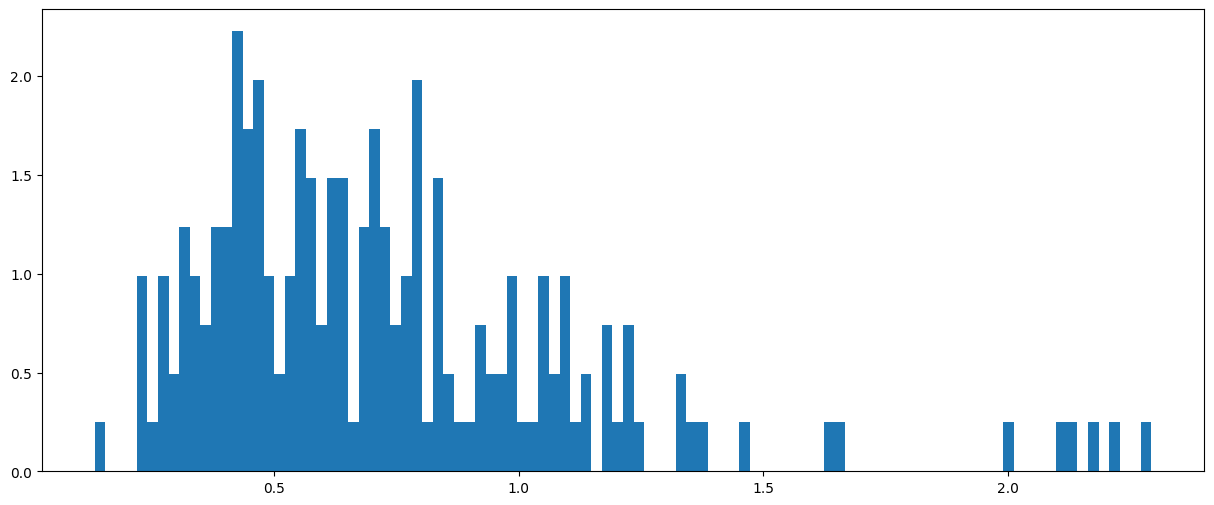

In [72]:
fig, ax = plt.subplots(1, 1)
fig.set_figheight(6)
fig.set_figwidth(15)
ax.hist(mo_features["rating"], density=True, bins=bins, histtype='stepfilled', alpha=1, 
                label = "rating")
plt.plot()

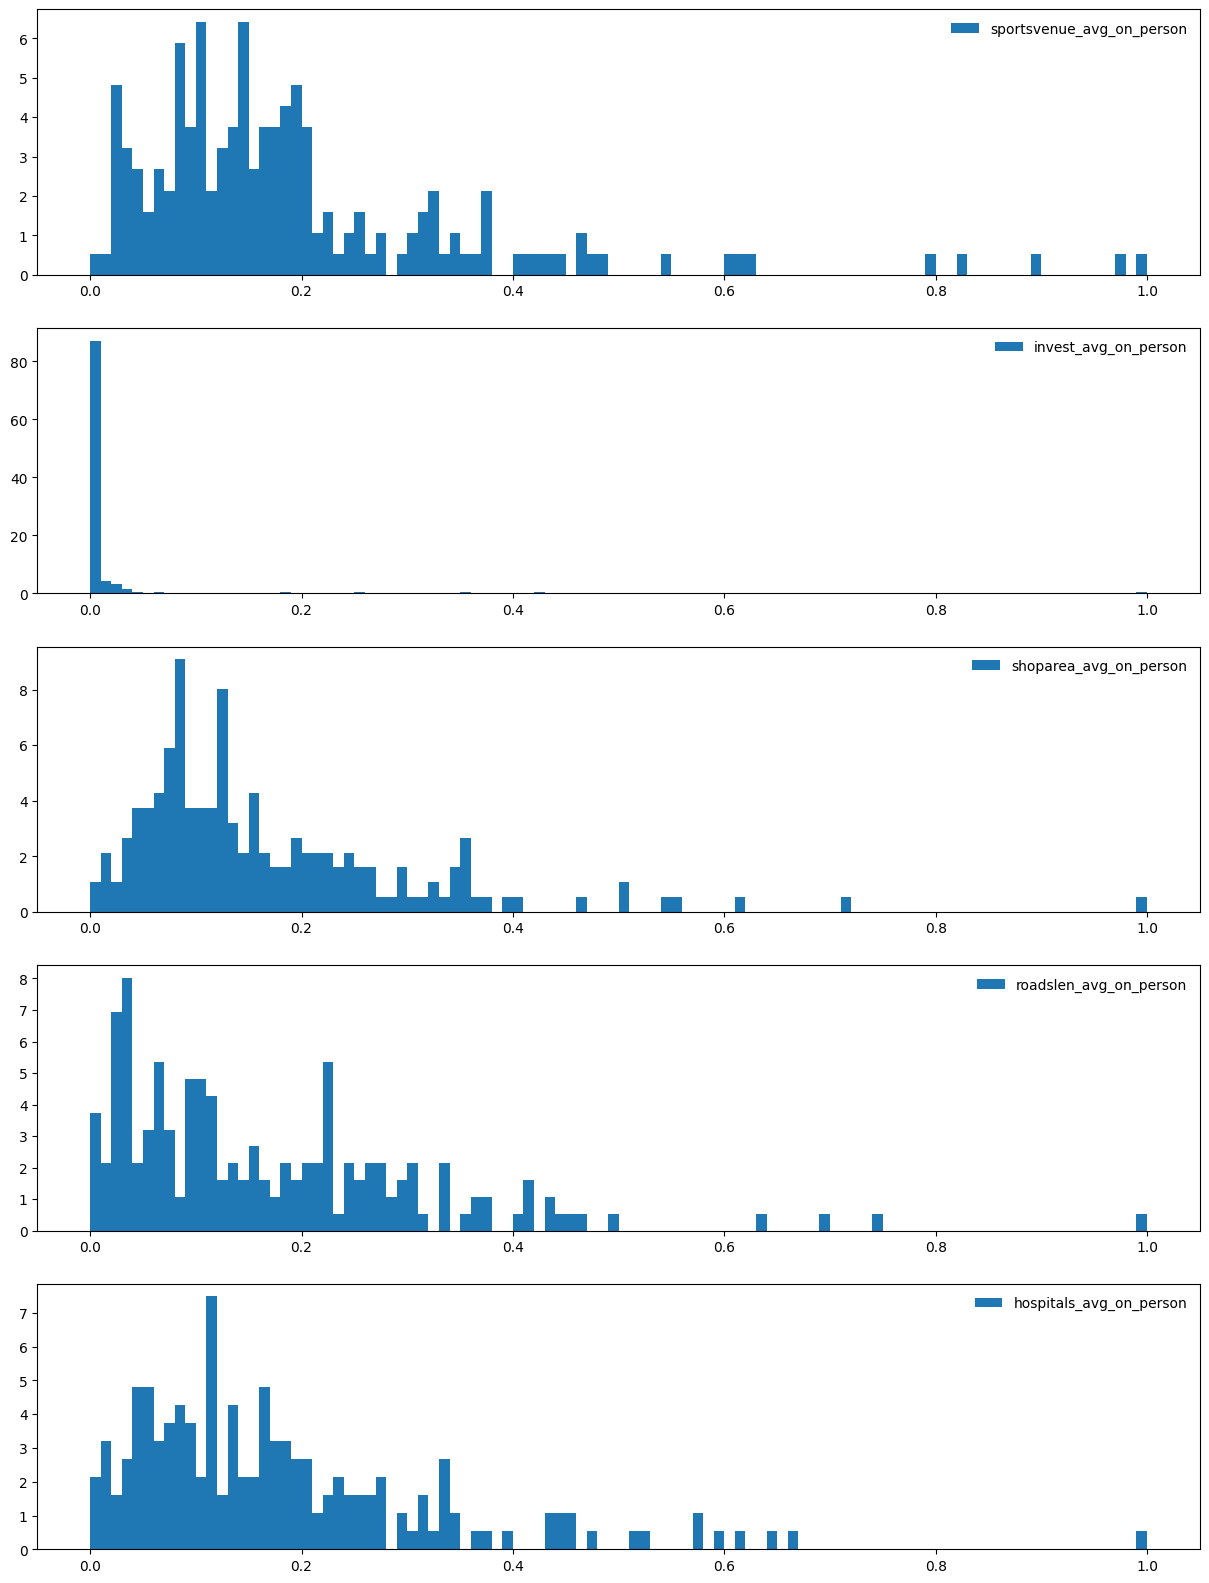

In [73]:
fig, axs = plt.subplots(5, 1)
fig.set_figheight(20)
fig.set_figwidth(15)
for i, ax in enumerate(axs):
        ax.hist(mo_features[AVG_FEATURE_NAMES[i]], density=True, bins=bins, histtype='stepfilled', alpha=1, 
                label = AVG_FEATURE_NAMES[i])
        ax.legend(loc='best', frameon=False)
        

In [74]:
@dataclass
class KParams:
    k0: float
    k1: float
    k2: float
    k4: float
    k5: float

In [75]:
mun_unit_population["student"] = ((mun_unit_population.age <= 22) & (mun_unit_population.age >= 16)).astype(int)
mun_unit_population.student.value_counts()

student
0    1725260
1     120385
Name: count, dtype: int64

In [76]:
mun_units

,name,popsize,sportsvenue_avg_on_person,invest_avg_on_person,shoparea_avg_on_person,roadslen_avg_on_person,hospitals_avg_on_person,latitude_dd,longitude_dd,inflow,outflow,saldo,saldo_rel,in_and_out_flow,rating
oktmo,,,,,,,,,,,,,,,
41625445,Суховское,1313,0.138136,0.000198,0.112360,0.302303,0.441135,60.022238,31.690957,12,21,-9,-0.006855,33,0.994132
41624427,Пчевжинское,1119,0.373041,0.000394,0.151224,0.331490,0.518993,59.349524,32.378016,16,25,-9,-0.008043,41,1.375141
41633408,Володарское,1378,0.351505,0.000978,0.035100,0.216519,0.205999,58.547738,29.820298,18,24,-6,-0.004354,42,0.810100
41609480,Свирицкое,662,0.194345,0.000105,0.164308,0.418028,0.437404,60.473611,32.767037,25,18,7,0.010574,43,1.214191
41648464,Шапкинское,439,0.485396,0.002910,0.141703,1.000000,0.663633,59.622407,31.209167,30,14,16,0.036446,44,2.293642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41612102,Сертоловское,61716,0.030507,0.000958,0.086450,0.003775,0.011155,60.144306,30.142639,3969,2246,1723,0.027918,6215,0.132844
41612402,Бугровское,31127,0.027477,0.029904,0.557027,0.020479,0.058349,60.109475,30.412377,4548,2033,2515,0.080798,6581,0.693236
41612101,Всеволожское,76974,0.115451,0.023415,0.321809,0.027115,0.110783,60.017857,30.697579,3574,3694,-120,-0.001559,7268,0.598573


In [77]:
def mig_prob(agent, mo_from, mo_to, KS: KParams):
    distance = get_distance(
       (mo_from.latitude_dd, mo_from.longitude_dd), 
       (mo_to.latitude_dd, mo_to.longitude_dd), 
    )
    return (
        mo_to.rating*KS.k0
        + KS.k1 * p1_mo_size(agent, mo_to.popsize)
        + KS.k2 * p2_conditional_distribution_age_and_distance(
            agent, distance) * p5_migration_intensity_by_age(agent)
        + agent.student * KS.k4 + p4_education_non_student(agent)
        - mo_from.rating * KS.k5
    )

In [78]:
mun_units

,name,popsize,sportsvenue_avg_on_person,invest_avg_on_person,shoparea_avg_on_person,roadslen_avg_on_person,hospitals_avg_on_person,latitude_dd,longitude_dd,inflow,outflow,saldo,saldo_rel,in_and_out_flow,rating
oktmo,,,,,,,,,,,,,,,
41625445,Суховское,1313,0.138136,0.000198,0.112360,0.302303,0.441135,60.022238,31.690957,12,21,-9,-0.006855,33,0.994132
41624427,Пчевжинское,1119,0.373041,0.000394,0.151224,0.331490,0.518993,59.349524,32.378016,16,25,-9,-0.008043,41,1.375141
41633408,Володарское,1378,0.351505,0.000978,0.035100,0.216519,0.205999,58.547738,29.820298,18,24,-6,-0.004354,42,0.810100
41609480,Свирицкое,662,0.194345,0.000105,0.164308,0.418028,0.437404,60.473611,32.767037,25,18,7,0.010574,43,1.214191
41648464,Шапкинское,439,0.485396,0.002910,0.141703,1.000000,0.663633,59.622407,31.209167,30,14,16,0.036446,44,2.293642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41612102,Сертоловское,61716,0.030507,0.000958,0.086450,0.003775,0.011155,60.144306,30.142639,3969,2246,1723,0.027918,6215,0.132844
41612402,Бугровское,31127,0.027477,0.029904,0.557027,0.020479,0.058349,60.109475,30.412377,4548,2033,2515,0.080798,6581,0.693236
41612101,Всеволожское,76974,0.115451,0.023415,0.321809,0.027115,0.110783,60.017857,30.697579,3574,3694,-120,-0.001559,7268,0.598573


In [79]:
mun_unit_population

,age,male,oktmo,educ,lnwage,children,student
350763,56,1,41603101,1,9.751864,2,0
2016734,46,1,41603101,1,9.859557,2,0
181352,69,0,41603101,1,8.963122,2,0
538846,33,1,41603101,3,10.134507,1,0
247260,48,1,41603101,1,9.760914,1,0
...,...,...,...,...,...,...,...
878376,16,0,41648464,1,9.301373,0,1
308756,49,1,41648464,1,9.379914,1,0
1523322,35,0,41648464,3,9.983811,1,0
1874884,22,1,41648464,2,9.794912,0,1


In [83]:
mig_prob(
    mun_unit_population.iloc[4],
    mun_units.iloc[45],
    mun_units.iloc[100],
    KS = KParams(1,1,1,1,1)
    
    
)

5354.885778110821

In [77]:
mun_units.sort_values("popsize", ascending=False)

,name,popsize,latitude_dd,longitude_dd,inflow,outflow,saldo,saldo_rel,in_and_out_flow
oktmo,,,,,,,,,
41612103,Муринское,90571,60.058750,30.448056,20224,7141,13083,0.144450,27365
41618101,Гатчинское,87626,59.565278,30.128056,2139,2459,-320,-0.003652,4598
41612101,Всеволожское,76974,60.017857,30.697579,3574,3694,-120,-0.001559,7268
41612155,Заневское,74137,59.931042,30.571007,12094,5627,6467,0.087230,17721
41615101,Выборгское,73001,60.714444,28.757222,1640,1660,-20,-0.000274,3300
...,...,...,...,...,...,...,...,...,...
41639404,Севастьяновское,653,61.071235,29.814444,26,33,-7,-0.010720,59
41642440,Черновское,610,59.197407,28.338704,10,37,-27,-0.044262,47
41645472,Коськовское,585,60.059883,33.351404,27,24,3,0.005128,51
